In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
loans = pd.read_csv('data/clean_data/other_loans.csv',low_memory=True, header=0)
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886956 entries, 0 to 886955
Data columns (total 52 columns):
Unnamed: 0                             886956 non-null int64
loan_amnt                              886956 non-null float64
funded_amnt                            886956 non-null float64
term                                   886956 non-null int64
int_rate                               886956 non-null float64
installment                            886956 non-null float64
emp_length                             886956 non-null float64
annual_inc                             886952 non-null float64
pymnt_plan                             886956 non-null int64
dti                                    886956 non-null float64
delinq_2yrs                            886927 non-null float64
inq_last_6mths                         886927 non-null float64
open_acc                               886927 non-null float64
total_rec_late_fee                     886956 non-null float64
pub_rec      

In [3]:
loans = loans.dropna()
loans.shape

(886927, 52)

In [4]:
y = loans['default'].values
X = loans.drop('default', axis=1).values

In [5]:
X.shape

(886927, 51)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [7]:
# instantiate random forest classifier
random_forest = RandomForestClassifier(max_depth=True)

# fit model to training data
print('fitting model to training data')
random_forest = random_forest.fit(X_train, y_train)

# test model performance
print('evaluating model performance')
score = random_forest.score(X_test, y_test)
print(score)

fitting model to training data
evaluating model performance
0.9986244686728377


In [8]:
y_pred = random_forest.predict(X_test)
conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred))
conf_matrx.columns = ['Predict: NO', 'Predict: YES']
conf_matrx.index = ['Actual: NO', 'Actual: YES']
conf_matrx

,Predict: NO,Predict: YES
Actual: NO,265713,0
Actual: YES,366,0


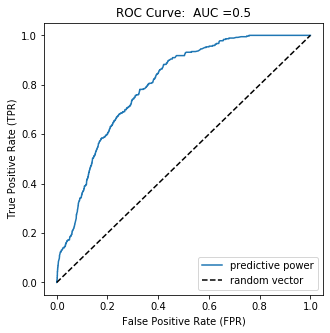

In [9]:
# predict probability
y_pred_prob = random_forest.predict_proba(X_test)[:,1]

# compute False Positive and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# compute Area under the curve
roc_auc = roc_auc_score(y_test, y_pred)

# plot ROC curve
title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
_ = plt.figure(figsize=(5,5))
_ = plt.plot(fpr, tpr)
_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.xlabel('False Positive Rate (FPR)')
_ = plt.ylabel('True Positive Rate (TPR)')
_ = plt.title(title)
_ = plt.legend(['predictive power','random vector'])

In [10]:
predictions = random_forest.predict(X_test)

In [11]:
loans.default.describe()

count    886927.000000
mean          0.001374
std           0.037048
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [12]:
np.mean(predictions)

0.0

In [13]:
sum(predictions)/len(predictions)

0.0

**Oh no, the model is predicting that all loans will not default, but SMOTE can be used to fix the class imbalance.**

In [14]:
# inspect class imbalance for defaulted loans
unique, count = np.unique(y_train, return_counts=True)
value_counts = {k:v for (k,v) in zip(unique, count)}
value_counts

{0: 619995, 1: 853}

In [15]:
# Applt Synthetic Minority Over-sampling Technique (SMOTE)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

In [16]:
# inspect balanced training data
unique, count = np.unique(y_train_bal, return_counts=True)
value_counts = {k:v for (k,v) in zip(unique, count)}
value_counts

{0: 619995, 1: 619995}

**Now, lets train the random forest on the balanced training set**

In [17]:
# instantiate random forest classifier
random_forest = RandomForestClassifier(max_depth=True)

# fit model to training data
print('fitting model to training data')
random_forest = random_forest.fit(X_train_bal, y_train_bal)

# test model performance
print('evaluating model performance')
score = random_forest.score(X_test, y_test)
print(score)

fitting model to training data
evaluating model performance
0.7132618508037086


In [29]:
y_pred = random_forest.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
conf_matrx = pd.DataFrame(confusion_matrix)
conf_matrx.columns = ['Predict: NO', 'Predict: YES']
conf_matrx.index = ['Actual: NO', 'Actual: YES']
conf_matrx

,Predict: NO,Predict: YES
Actual: NO,189533,76180
Actual: YES,115,251


In [31]:
tp = confusion_matrix[1,1]
tn = confusion_matrix[0,0]
fp = confusion_matrix[0,1]
fn = confusion_matrix[1,0]

TPR = (tp)/(tp + fn)
FPR = (fp)/(fp + tn)

TPR:  0.686 	FPR:  0.287


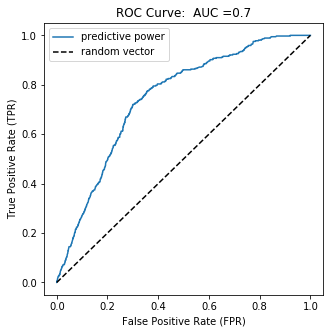

In [33]:
# predict probability
y_pred_prob = random_forest.predict_proba(X_test)[:,1]

# compute False Positive and True Positive Rate for ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# compute Area under the curve
roc_auc = roc_auc_score(y_test, y_pred)

# plot ROC curve
title = 'ROC Curve:  AUC =' + str(roc_auc.round(3))
_ = plt.figure(figsize=(5,5))
_ = plt.plot(fpr, tpr)
_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.xlabel('False Positive Rate (FPR)')
_ = plt.ylabel('True Positive Rate (TPR)')
_ = plt.title(title)
_ = plt.legend(['predictive power','random vector'])

print('TPR: ', TPR.round(3), '\tFPR: ', FPR.round(3))

**True Positive (TP) -  prediction: TRUE & actual label: TRUE**  
    'Correctly classified as True'  
    TPR = (TP) / (TP + FN)
    
    

**True Negative (TN) -  prediction: FALSE & actual label: FALSE**  
    'Correctly classified as False'  
    


**False Positive (FP) -  prediction: TRUE & actual label: FALSE**  
    'Incorectly classified as True'  
    FPR = (FP) / (FP + TN)
    
    
    
**False Negative (FN) -  prediction: FALSE & actual label: TRUE**  
    'Incorrectly classified as False'  


In [20]:
CONFUSION_MATRIX = pd.DataFrame()
CONFUSION_MATRIX['Predict: NO'] = ['TN','FN']
CONFUSION_MATRIX['Predict: YES'] = ['FP','TP']
CONFUSION_MATRIX.index = ['Actual: NO', 'Actual: YES']
CONFUSION_MATRIX

,Predict: NO,Predict: YES
Actual: NO,TN,FP
Actual: YES,FN,TP


**We only care about predicting default correctly. Its ok to reject borrowers that might that are predicted to default, but might actually repay the loan in full. But, it is bad to misclassify a borrower that will actually default on the loan. We want to correctly identify all potential borrowers that will default on their loans. Therefore, TPR will measure the model's ability to correctly classify loans that will default and FPR. It is in the bank's best interest to minimize the amount of FALSE NEGATIVES. This is where the bank will lose money because the model has wrongfully approved a borrower that will eventually default on their loan.**